In [ ]:
!pip install catboost pycaret optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import optuna
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [ ]:
from pycaret.classification import *

In [ ]:
Train_data = pd.read_csv('/content/train.csv')
Test_data = pd.read_csv('/content/test.csv')
Train_data

,index,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation,price
0,0,Secondary,Ботанический сад,13,Moscow,3,52.89,25.0,12.6,3,10,European-style renovation,18084832.0
1,1,New building,Нагатинская,23,Moscow,2,44.25,25.5,10.0,8,17,Cosmetic,16737304.0
2,2,Secondary,Аминьевская,5,Moscow,3,70.74,28.8,9.6,7,22,Cosmetic,35301363.0
3,3,Secondary,Белорусская,12,Moscow,3,37.91,28.2,11.5,6,9,Without renovation,14619353.0
4,4,New building,Кантемировская,19,Moscow,1,49.30,15.9,24.3,2,10,Cosmetic,13235613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30363,30363,Secondary,Бунинская аллея,16,Moscow,3,22.61,11.7,6.3,29,5,European-style renovation,5546540.0
30364,30364,Secondary,Савеловская,14,Moscow,3,87.40,51.9,19.3,3,35,Without renovation,39386266.0
30365,30365,Secondary,Фили,19,Moscow,4,91.03,49.2,18.9,20,37,Designer,32198037.0
30366,30366,Secondary,ЗИЛ,13,Moscow,5,267.59,191.1,28.1,7,5,European-style renovation,364926089.0


In [ ]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30368 entries, 0 to 30367
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             30368 non-null  int64  
 1   apartment_type    30368 non-null  object 
 2   metro_station     30368 non-null  object 
 3   minutes_to_metro  30368 non-null  int64  
 4   region            30368 non-null  object 
 5   number_of_rooms   30368 non-null  int64  
 6   area              30368 non-null  float64
 7   living_area       30368 non-null  float64
 8   kitchen_area      30368 non-null  float64
 9   floor             30368 non-null  int64  
 10  number_of_floors  30368 non-null  int64  
 11  renovation        30368 non-null  object 
 12  price             30368 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
Train_data.isna().sum()
Train_data.duplicated().sum()
#Train_data['target'].value_counts() #0: 11086; 1: 5543

0

array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'minutes_to_metro'}>,
        <Axes: title={'center': 'number_of_rooms'}>],
       [<Axes: title={'center': 'area'}>,
        <Axes: title={'center': 'living_area'}>,
        <Axes: title={'center': 'kitchen_area'}>],
       [<Axes: title={'center': 'floor'}>,
        <Axes: title={'center': 'number_of_floors'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

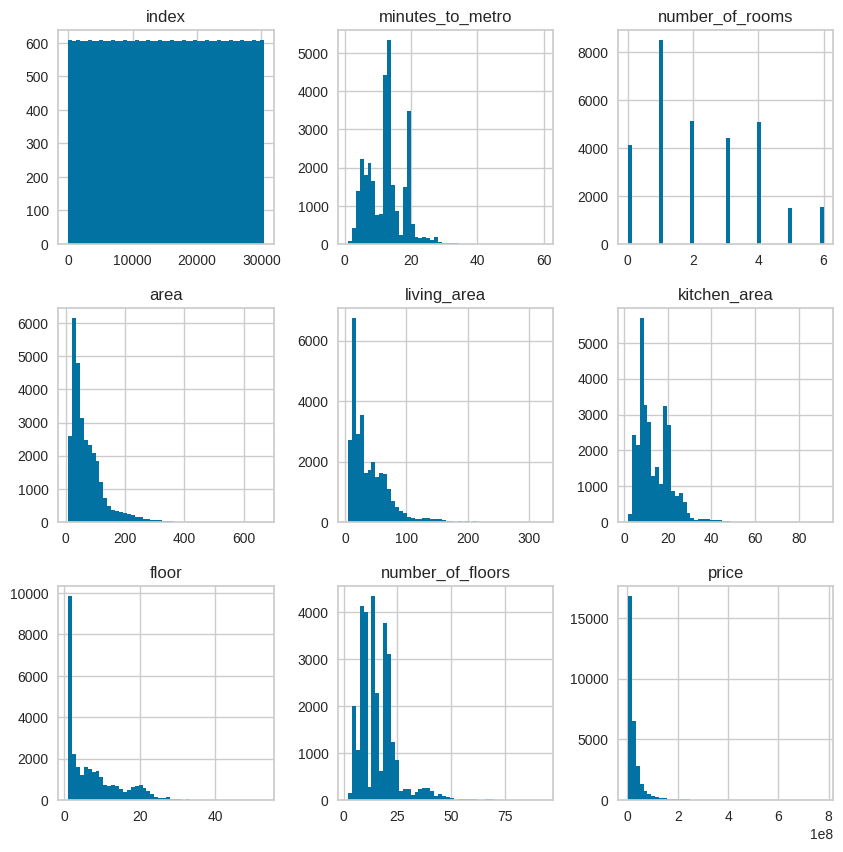

In [ ]:
Train_data.hist(bins=50, figsize=(10, 10))

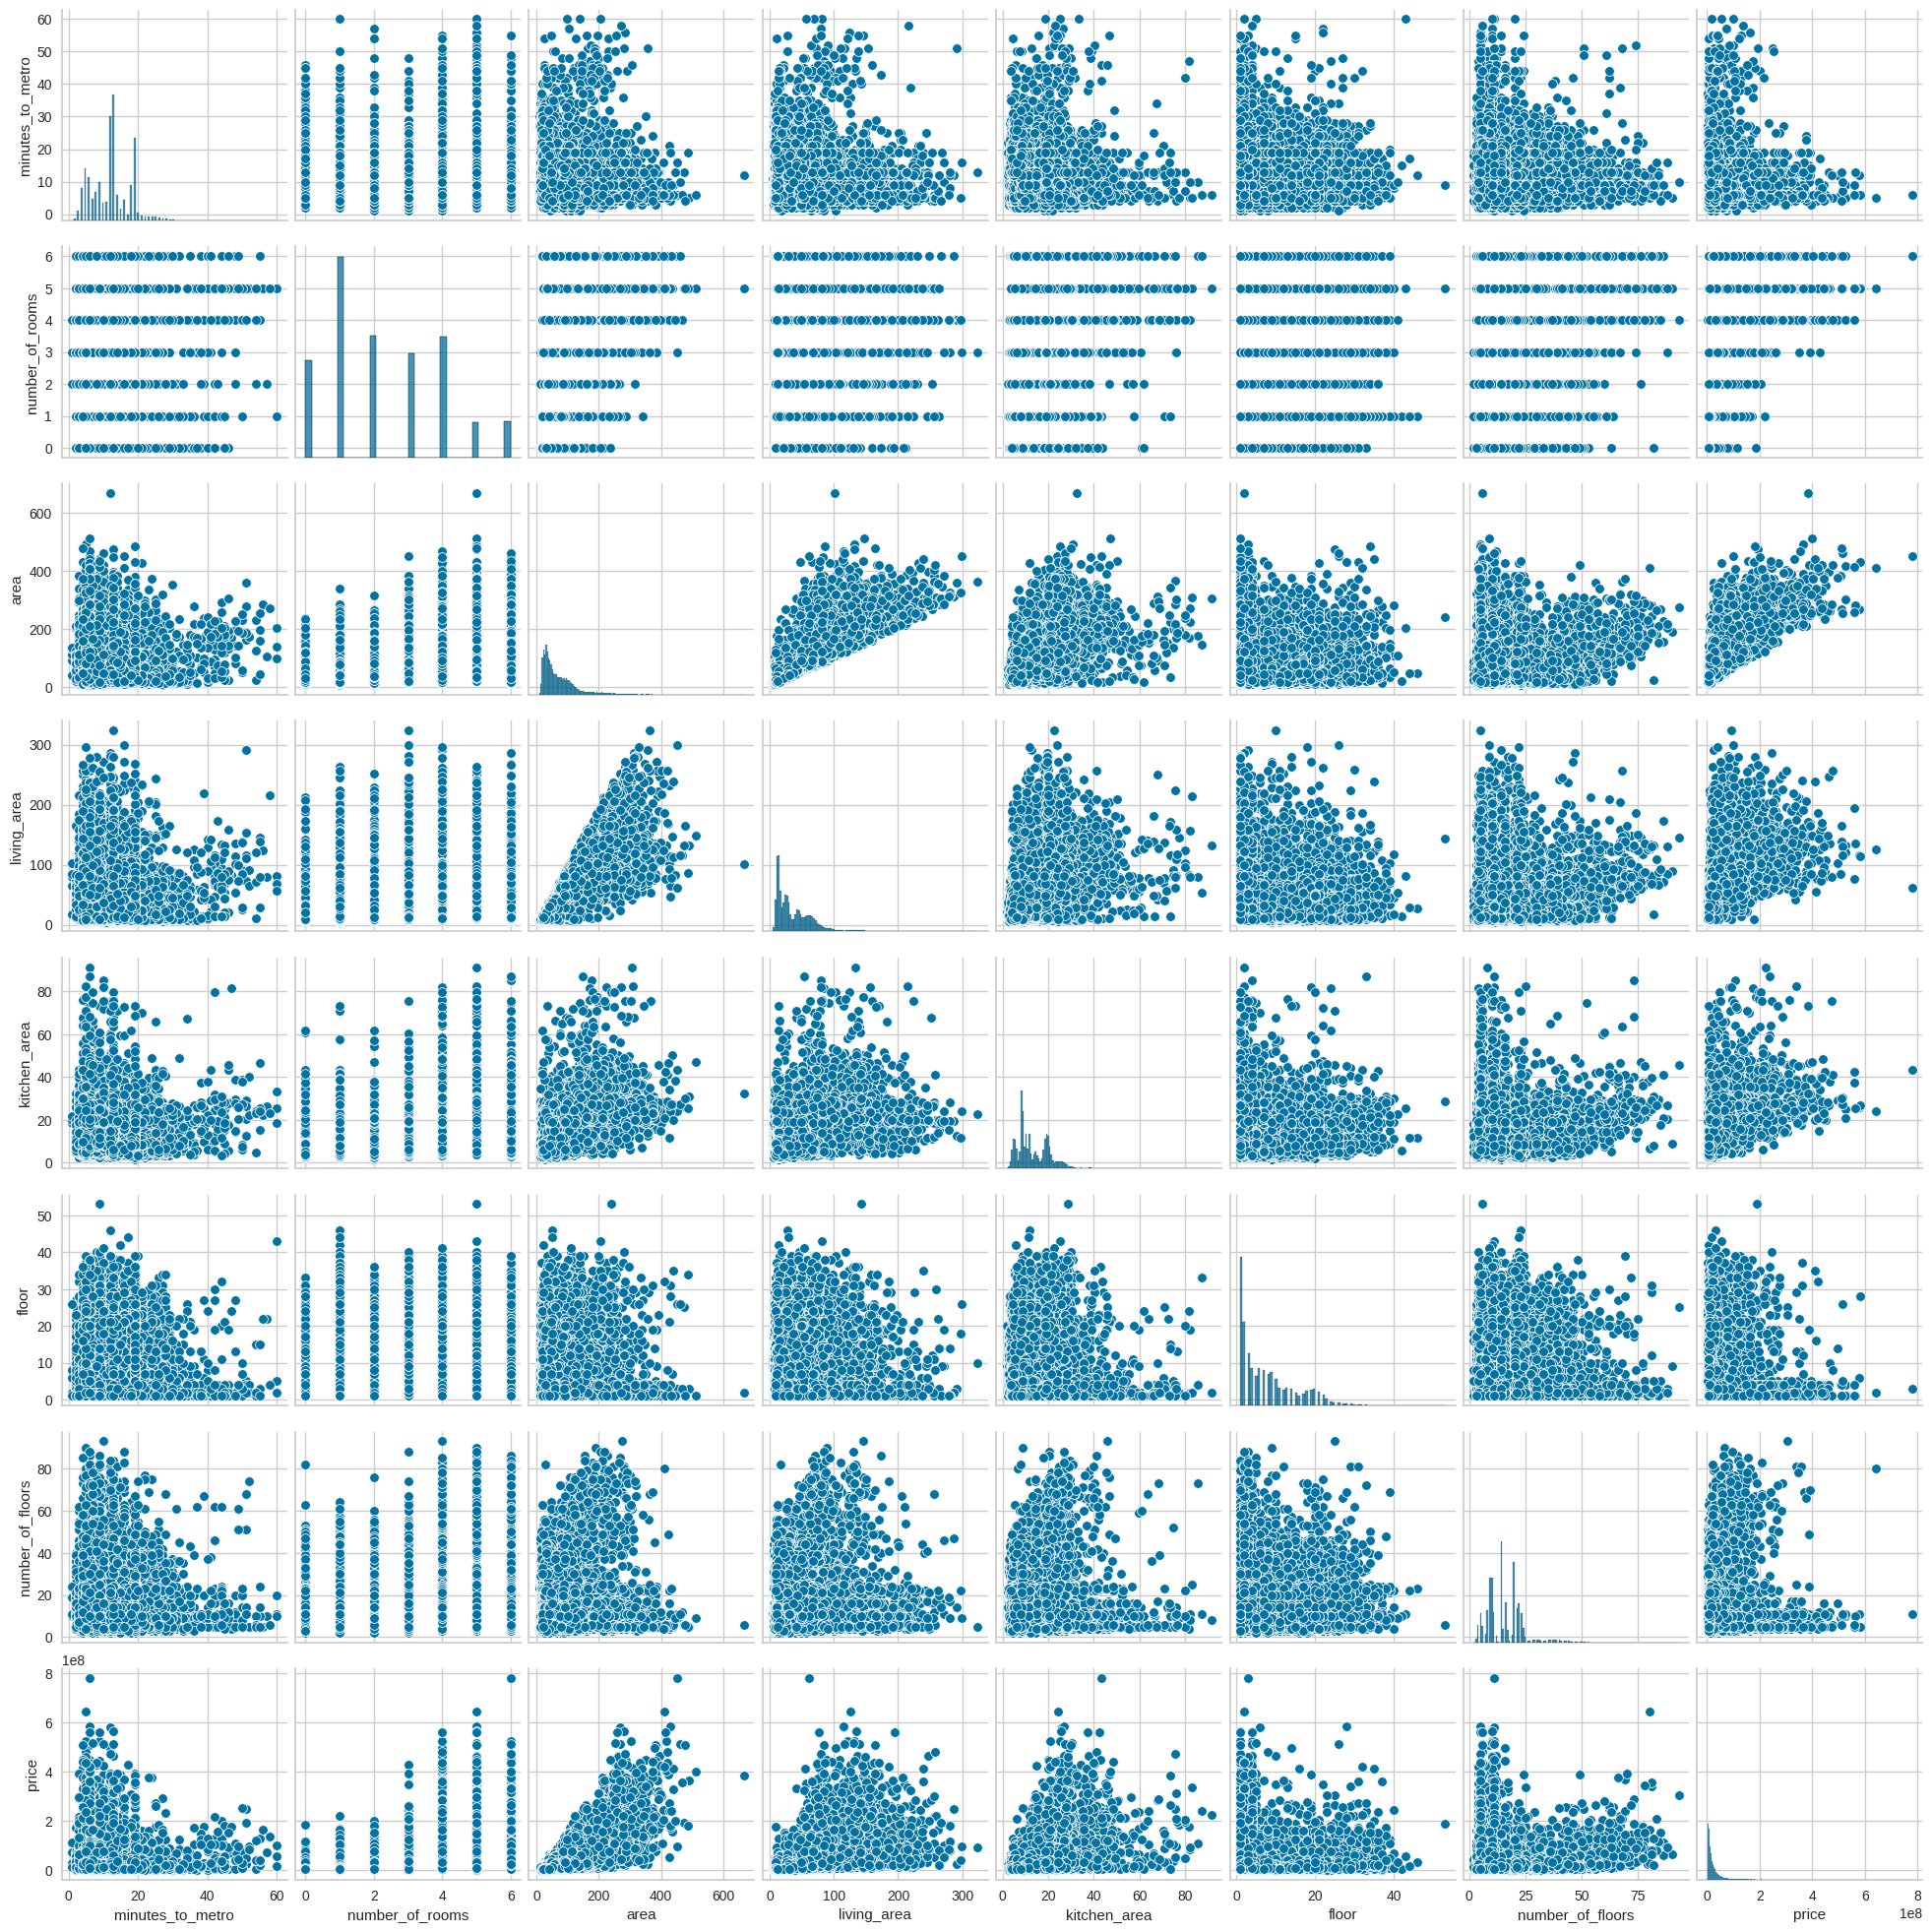

In [ ]:
import seaborn as sns
sns.pairplot(Train_data.drop(columns='index'))

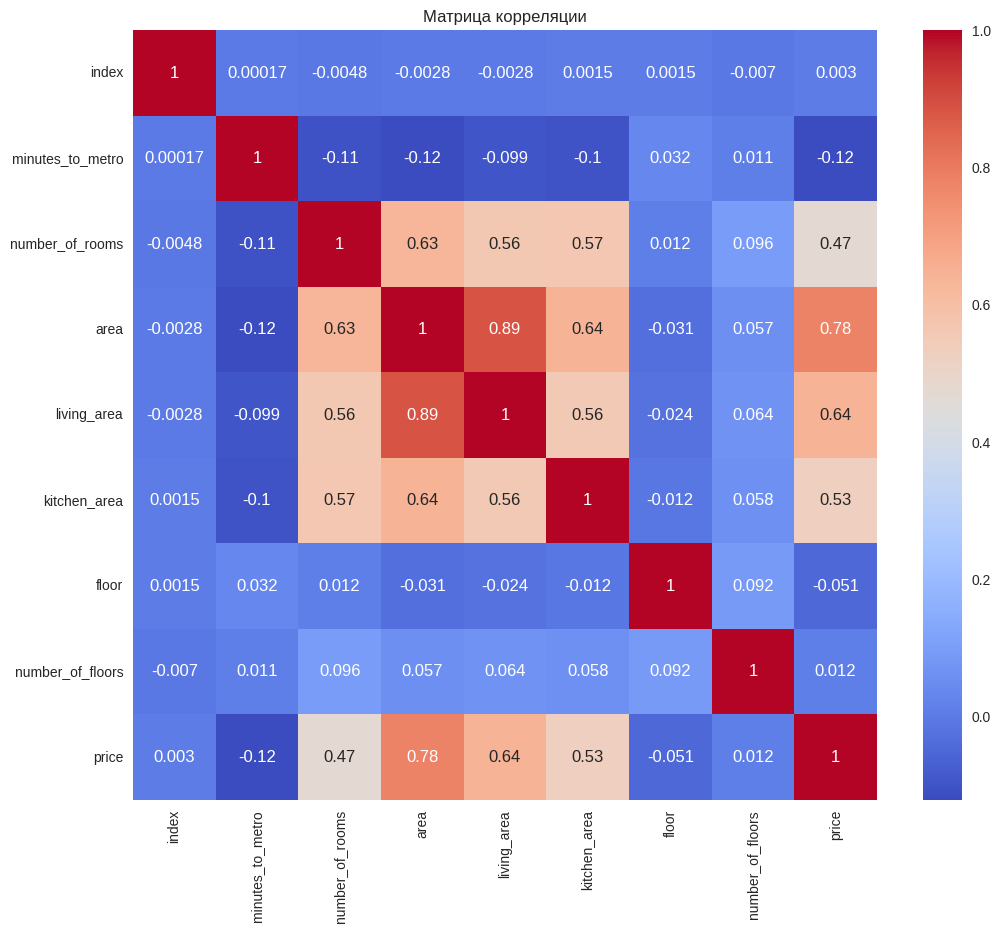

In [ ]:
numeric_df = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']) # и другие числовые типы, если есть
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

In [ ]:
y = Train_data['price']
y = np.log1p(y)
X = Train_data.drop(columns=['price']) #30368

In [ ]:
big_data = pd.concat([X, Test_data])
big_data

,index,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,0,Secondary,Ботанический сад,13,Moscow,3,52.89,25.0,12.6,3,10,European-style renovation
1,1,New building,Нагатинская,23,Moscow,2,44.25,25.5,10.0,8,17,Cosmetic
2,2,Secondary,Аминьевская,5,Moscow,3,70.74,28.8,9.6,7,22,Cosmetic
3,3,Secondary,Белорусская,12,Moscow,3,37.91,28.2,11.5,6,9,Without renovation
4,4,New building,Кантемировская,19,Moscow,1,49.30,15.9,24.3,2,10,Cosmetic
...,...,...,...,...,...,...,...,...,...,...,...,...
7587,7587,Secondary,Комсомольская,9,Moscow,4,109.78,60.6,15.6,2,10,Designer
7588,7588,Secondary,Алма-Атинская,13,Moscow region,2,29.31,15.2,10.9,1,22,Cosmetic
7589,7589,Secondary,Лермонтовский проспект,6,Moscow,4,90.61,56.0,20.6,23,27,European-style renovation
7590,7590,New building,Полянка,5,Moscow,4,82.14,46.2,20.6,10,28,Without renovation


In [ ]:
def aaa(data):
  for column in ['minutes_to_metro', 'area', 'living_area', 'kitchen_area','floor']: # Квадрат
      data[f'{column}_squared'] = data[column] **2
  for column in ['minutes_to_metro', 'area', 'living_area', 'kitchen_area']: # Логарифмирование
      data[f'{column}_log'] = np.log1p(data[column])
  for column in ['area', 'living_area', 'kitchen_area']: # Экспонента
      data[f'{column}_exp'] = np.exp(data[column])
  for column in ['minutes_to_metro', 'area', 'living_area', 'kitchen_area']: # Синус-Косинус
      data[f'{column}_sin'] = np.sin(data[column])
      data[f'{column}_cos'] = np.cos(data[column])
  data['area_to_living_area_ratio'] = data['area'] / data['living_area']
  data['area_to_kitchen_ratio'] = data['area'] / data['kitchen_area']
  data['living_area_to_kitchen_ratio'] = data['living_area'] / data['kitchen_area']
  data['area_per_room'] = data['area'] / data['number_of_rooms']
  data['living_area_per_room'] = data['living_area'] / data['number_of_rooms']
  data['relative_floor'] = data['floor'] / data['number_of_floors']
  data['is_first_floor'] = (data['floor'] == 1).astype(int)
  data['is_last_floor'] = (data['floor'] == data['number_of_floors']).astype(int)
  data['region_metro'] = data['region'] + '_' + data['metro_station']
  data['floor_renovation'] = data['floor'].astype(str) + '_' + data['renovation']
  data['area_times_rooms'] = data['area'] * data['number_of_rooms']
  data['living_area_times_rooms'] = data['living_area'] * data['number_of_rooms']
  data['floor_times_floors'] = data['floor'] * data['number_of_floors']
  return data

In [ ]:
big_data = aaa(big_data)

In [ ]:
X = big_data[:30368].drop(columns='index')
test = big_data[30368:].drop(columns='index')

In [ ]:
X

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
cat_features = ['apartment_type', 'metro_station', 'region', 'renovation', 'region_metro', 'floor_renovation']


#Экспериментальная модель


In [ ]:
s = setup(data=X, target=y, remove_outliers=True)

,Description,Value
0,Session id,4593
1,Target,target
2,Target type,Binary
3,Original data shape,"(16623, 8)"
4,Transformed data shape,"(16041, 8)"
5,Transformed train set shape,"(11054, 8)"
6,Transformed test set shape,"(4987, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8496,0.9174,0.8906,0.8848,0.8876,0.6603,0.6605,5.8310
lightgbm,Light Gradient Boosting Machine,0.8472,0.9151,0.8879,0.8837,0.8857,0.6552,0.6554,1.2260
gbc,Gradient Boosting Classifier,0.8423,0.9101,0.8870,0.8779,0.8824,0.6431,0.6433,1.9200
xgboost,Extreme Gradient Boosting,0.8409,0.9099,0.8822,0.8796,0.8809,0.6414,0.6415,0.6130
rf,Random Forest Classifier,0.8363,0.9050,0.8817,0.8741,0.8778,0.6298,0.6300,1.7790
et,Extra Trees Classifier,0.8338,0.9038,0.8805,0.8716,0.8760,0.6239,0.6241,0.9020
ada,Ada Boost Classifier,0.8297,0.8978,0.8716,0.8729,0.8722,0.6168,0.6169,0.6090
qda,Quadratic Discriminant Analysis,0.8266,0.8922,0.8308,0.9016,0.8647,0.6243,0.6286,0.3850
lr,Logistic Regression,0.8237,0.8904,0.8774,0.8610,0.8691,0.5994,0.5997,0.9680
lda,Linear Discriminant Analysis,0.8177,0.8889,0.8620,0.8644,0.8632,0.5902,0.5904,0.3580


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
catboost = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8393,0.9056,0.8763,0.8820,0.8791,0.6397,0.6397
1,0.8454,0.9167,0.8866,0.8821,0.8843,0.6512,0.6512
2,0.8376,0.9123,0.8827,0.8748,0.8788,0.6330,0.6331
3,0.8514,0.9105,0.8814,0.8941,0.8877,0.6679,0.6681
4,0.8282,0.9039,0.8853,0.8609,0.8729,0.6078,0.6084
5,0.8308,0.9034,0.8905,0.8605,0.8752,0.6125,0.6133
6,0.8504,0.9225,0.8943,0.8830,0.8886,0.6609,0.6610
7,0.8555,0.9136,0.8982,0.8868,0.8924,0.6726,0.6727
8,0.8426,0.9089,0.8866,0.8787,0.8826,0.6440,0.6441


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_catboost = tune_model(catboost, optimize='F1', n_iter=20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8436,0.9091,0.8905,0.8769,0.8836,0.6455,0.6456
1,0.8419,0.9168,0.8866,0.8776,0.8821,0.6425,0.6426
2,0.8454,0.9169,0.8905,0.8791,0.8848,0.6498,0.6499
3,0.8531,0.9106,0.8918,0.8883,0.8900,0.6688,0.6688
4,0.8282,0.9032,0.8853,0.8609,0.8729,0.6078,0.6084
5,0.8376,0.9049,0.9021,0.8610,0.8811,0.6257,0.6274
6,0.8469,0.9240,0.8956,0.8775,0.8865,0.6517,0.6520
7,0.8555,0.9127,0.9021,0.8838,0.8929,0.6713,0.6716
8,0.8418,0.9135,0.8853,0.8785,0.8819,0.6423,0.6424


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [ ]:
Test_data

,index,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover,et0_fao_evapotranspiration,sunshine_duration,shortwave_radiation_instant
0,0,19.2960,46.503178,7.5460,27.000002,0.150875,3600.0000,184.567800
1,1,20.8960,74.035706,16.0960,31.800001,0.211327,3600.0000,384.852800
2,2,2.6460,89.843414,1.1460,100.000000,0.002671,0.0000,0.000000
3,3,7.8725,91.807570,6.6225,36.600000,0.000000,0.0000,0.000000
4,4,2.0225,84.124054,-0.3775,100.000000,0.002527,0.0000,0.000000
...,...,...,...,...,...,...,...,...
4153,4153,13.8225,41.254710,0.8725,100.000000,0.199135,3600.0000,349.583650
4154,4154,20.3960,57.198450,11.6460,34.800003,0.298315,3600.0000,377.446040
4155,4155,12.8460,81.441060,9.7460,26.400002,0.049897,3035.8867,115.651184
4156,4156,1.7960,94.766070,1.0460,78.600000,0.000000,0.0000,0.000000


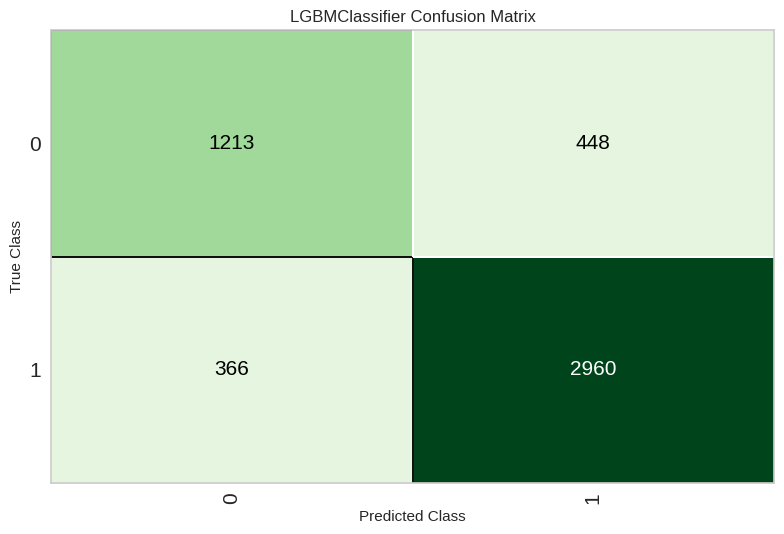

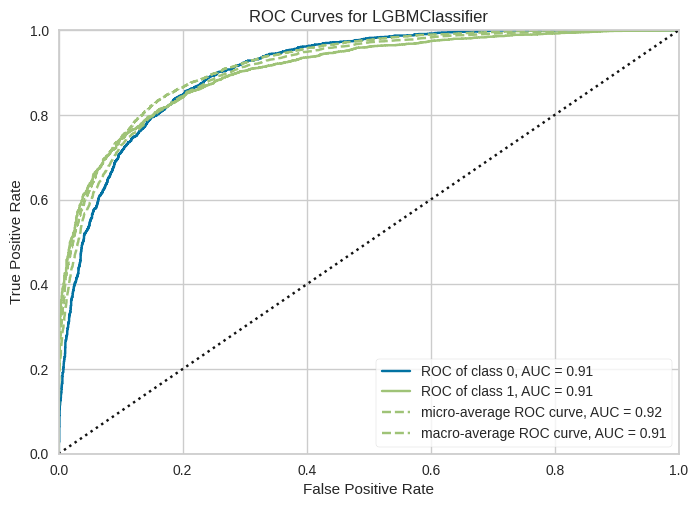

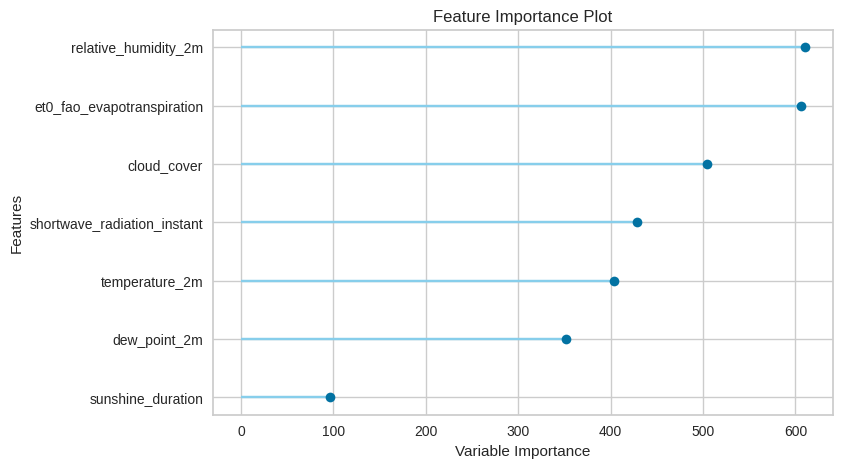

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
plot_model(tuned_catboost, plot = 'confusion_matrix')
plot_model(tuned_catboost, plot = 'auc')
plot_model(tuned_catboost, plot = 'feature')
evaluate_model(tuned_catboost)

In [ ]:
test_data_transformed = predict_model(tuned_catboost, data=Test_data.drop(columns='index'))
print(test_data_transformed)

      temperature_2m  relative_humidity_2m  dew_point_2m  cloud_cover  \
0            19.2960             46.503178      7.546000    27.000002   
1            20.8960             74.035706     16.096001    31.800001   
2             2.6460             89.843414      1.146000   100.000000   
3             7.8725             91.807571      6.622500    36.599998   
4             2.0225             84.124054     -0.377500   100.000000   
...              ...                   ...           ...          ...   
4153         13.8225             41.254711      0.872500   100.000000   
4154         20.3960             57.198448     11.646000    34.800003   
4155         12.8460             81.441063      9.746000    26.400002   
4156          1.7960             94.766068      1.046000    78.599998   
4157          3.3460             64.316162     -2.754000    59.099998   

      et0_fao_evapotranspiration  sunshine_duration  \
0                       0.150875        3600.000000   
1            

In [ ]:
test_pred = test_data_transformed['prediction_label']

In [ ]:
save_model(tuned_catboost, 'tuned_catboost_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['temperature_2m',
                                              'relative_humidity_2m',
                                              'dew_point_2m', 'cloud_cover',
                                              'et0_fao_evapotranspiration',
                                              'sunshine_duration',
                                              'shortwave_radiation_instant'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=Fa...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 cols

#Модель


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
def objective(trial):
    params = {
        'verbose': 1,
        'random_seed': 42,
        'use_best_model': True,
        'devices':'cuda',
        'loss_function':'MAPE',
        'iterations': trial.suggest_int('iterations', 100, 2500),  # Количество итераций
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, log=True),  # Скорость обучения
        'depth': trial.suggest_int('depth', 3, 14),  # Глубина деревьев
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 10),  # L2-регуляризация
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Случайная сила (для шума)
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Температура бэггинга
        'border_count': trial.suggest_int('border_count', 32, 255),  # Количество границ для разделения
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 110),  # Минимальное количество данных в листе
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),  # Итерации оценки листьев
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),  # Стратегия роста
        }

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=25)

    preds = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, preds)

    return mape

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=35)

best_trial = study.best_trial
print(f"Лучшие параметры: {best_trial}")

[I 2025-01-25 20:10:57,331] A new study created in memory with name: no-name-70cbfec9-73ce-4ae9-bb60-9d35b50bf1d2
[W 2025-01-25 20:10:57,352] Trial 0 failed with parameters: {'iterations': 727, 'learning_rate': 0.085514379036383, 'depth': 14, 'l2_leaf_reg': 3.1822238779417162, 'random_strength': 8.516715038652466, 'bagging_temperature': 0.9483253770243426, 'border_count': 192, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 7, 'grow_policy': 'SymmetricTree'} because of the following error: ValueError("'region_metro' is not in list").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-95-2ff7d89e3981>", line 20, in objective
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/catbo

ValueError: 'region_metro' is not in list

In [ ]:
best_params = study.best_params
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'iterations': 656, 'depth': 9, 'learning_rate': 0.025065521424781988, 'l2_leaf_reg': 0.0004603995494952455, 'min_data_in_leaf': 42}


In [ ]:
best_params = {'iterations': 656, 'depth': 8, 'learning_rate': 0.025065521424781988, 'l2_leaf_reg': 0.0004603995494952455, 'min_data_in_leaf': 42}

In [ ]:
best_model = CatBoostClassifier(**best_params,
                                eval_metric= 'TotalF1',
                                random_seed= 42,
                                use_best_model= True,
                                devices='cuda',
                                loss_function='Logloss',)
best_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=30)

0:	learn: 0.8226077	test: 0.8226277	best: 0.8226277 (0)	total: 11.1ms	remaining: 7.29s
1:	learn: 0.8237625	test: 0.8278682	best: 0.8278682 (1)	total: 21.2ms	remaining: 6.94s
2:	learn: 0.8234899	test: 0.8261901	best: 0.8278682 (1)	total: 30.9ms	remaining: 6.72s
3:	learn: 0.8270089	test: 0.8285582	best: 0.8285582 (3)	total: 40.8ms	remaining: 6.65s
4:	learn: 0.8275934	test: 0.8296221	best: 0.8296221 (4)	total: 50.5ms	remaining: 6.58s
5:	learn: 0.8272714	test: 0.8303589	best: 0.8303589 (5)	total: 60.3ms	remaining: 6.53s
6:	learn: 0.8271375	test: 0.8304438	best: 0.8304438 (6)	total: 70.1ms	remaining: 6.5s
7:	learn: 0.8279601	test: 0.8297256	best: 0.8304438 (6)	total: 80.2ms	remaining: 6.49s
8:	learn: 0.8292470	test: 0.8298556	best: 0.8304438 (6)	total: 90.4ms	remaining: 6.5s
9:	learn: 0.8291771	test: 0.8311727	best: 0.8311727 (9)	total: 103ms	remaining: 6.62s
10:	learn: 0.8299947	test: 0.8316290	best: 0.8316290 (10)	total: 112ms	remaining: 6.56s
11:	learn: 0.8295593	test: 0.8329110	best: 0.

In [ ]:
y_pred_best = best_model.predict(X_valid)

y_pred_best_prob = best_model.predict_proba(X_valid)[:, 1]

In [ ]:
y_pred_best_prob

array([0.50544164, 0.28662164, 0.99915813, ..., 0.98989031, 0.99228552,
       0.66252337])

In [ ]:
y_pred_best

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
log_loss_value = log_loss(y_valid, y_pred_best_prob)
print(f'Log Loss: {log_loss_value}')

Log Loss: 0.36505397923153826


In [ ]:
f1_best = f1_score(y_valid, y_pred_best)
print(f"Recall CatBoost: {f1_best}")


Recall CatBoost: 0.8839432412247946


In [ ]:
def find_best_threshold(y_pred_prob, y_true):
    """
    Находит оптимальный порог для бинарной классификации, максимизирующий F1-меру.

    Args:
        y_pred_prob: Массив вероятностей принадлежности к положительному классу.
        y_true: Массив истинных меток (бинарные значения).

    Returns:
        Кортеж: (оптимальный порог, максимальное значение F1-меры).
    """
    best_threshold = 0
    best_f1 = 0

    thresholds = np.linspace(0, 1, 1000) # Создаем множество порогов от 0 до 1

    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int) # Преобразование вероятностей в бинарные предсказания
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

best_threshold, best_f1 = find_best_threshold(y_pred_best_prob, y_valid)

print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"Максимальное значение F1-меры: {best_f1:.4f}")


# Применение оптимального порога:
y_pred_best_optimized = (y_pred_best_prob >= best_threshold).astype(int)
f1_optimized = f1_score(y_valid, y_pred_best_optimized)
print(f"F1-мера с оптимальным порогом: {f1_optimized:.4f}")

Оптимальный порог: 0.4354
Максимальное значение F1-меры: 0.8862
F1-мера с оптимальным порогом: 0.8862


#Тестирование

In [ ]:
X_test = scaler.transform(Test_data.drop(columns='index'))

NameError: name 'scaler' is not defined

In [ ]:
test_pred_prob = best_model.predict_proba(X_test)[:,1]

In [ ]:
test_pred_prob

array([0.96845539, 0.48359859, 0.19141433, ..., 0.81328932, 0.71500305,
       0.78120061])

4987

In [ ]:
threshold = 0.453


test_pred = (test_pred_prob >= threshold).astype(int)

print(test_pred)

[1 1 0 ... 1 1 1]


In [ ]:
submission = pd.DataFrame({
    'id': Test_data['index'],
    'target': test_pred
})

submission.to_csv('submission.csv', index=False)
print("Файл с предсказаниями сохранен как submission.csv")

Файл с предсказаниями сохранен как submission.csv


In [ ]:
submission

,id,target
0,0,1
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
4153,4153,1
4154,4154,1
4155,4155,1
4156,4156,1


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score
import numpy as np

# Если у вас есть истинные метки для тестовых данных
y_true = ...  # ваши истинные метки

# Поиск оптимального порога по ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, test_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_roc = thresholds[optimal_idx]

print(f"Оптимальный порог по ROC: {optimal_threshold_roc:.4f}")

In [ ]:
# Поиск порога, максимизирующего F1-score
best_threshold = 0
best_f1 = 0

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred = (test_pred >= threshold).astype(int)
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Оптимальный порог по F1: {best_threshold:.4f}")
print(f"Лучший F1-score: {best_f1:.4f}")